# Numerical experiments

First, import necessary libraries and functions.

In [9]:
# This is a Python 2 notebook, but may work in Python 3
from __future__ import print_function, division

# Jupyter setup
%matplotlib inline
from IPython.display import display
import pylab
pylab.rcParams['figure.figsize'] = 10, 8
import matplotlib.pyplot as plt



Then, import the AD class.

In [3]:
# %load adclass/valjac.py
from __future__ import division
from exceptions import NotImplementedError

import numpy as np
import sympy as sp

def dot(A, x):
    """Matrix multiplication."""
    assert isinstance(A, np.matrix)

    # Ordinary numpy multiplication if possible
    if not isinstance(x, ValJac):
        return A*x

    return ValJac(A*x.val, A*x.jac)

def multiply(x, y):
    """Element-wise multiplication. Similar to .* in Matlab."""

    # Both matrix
    if isinstance(x, np.matrix) and isinstance(y, np.matrix):
        return np.multiply(x, y)

    # Both ValJac
    if isinstance(x, ValJac) and isinstance(y, ValJac):
        assert x.val.shape[0] == y.val.shape[0]
        assert x.val.shape[1] == y.val.shape[1]
        assert x.jac.shape[0] == y.jac.shape[0]
        assert x.jac.shape[1] == y.jac.shape[1]
        return ValJac(np.multiply(x.val, y.val),
                np.multiply(x.val, y.jac) + np.multiply(y.val, x.jac))

    # First matrix, second ValJac
    if isinstance(x, np.matrix) and isinstance(y, ValJac):
        assert x.shape[0] == y.val.shape[0]
        assert x.shape[1] == y.val.shape[1]
        return ValJac(np.multiply(x, y.val), np.multiply(x, y.jac))

    # First ValJac, second matrix
    if isinstance(x, ValJac) and isinstance(y, np.matrix):
        assert x.val.shape[0] == y.shape[0]
        assert x.val.shape[1] == y.shape[1]
        return ValJac(np.multiply(x.val, y), np.multiply(x.jac, y))

    raise NotImplementedError("Only ValJac and np.matrix are supported")

def exp(x):
    """Elementwise exponentiation."""
    if isinstance(x, ValJac):
        ex = np.exp(x.val)
        return ValJac(ex, np.multiply(x.jac, ex))
    else:
        return np.exp(x)

def vstack(l):
    """
    Stack vectors vertically.

    Case 1: No objects are Valjac objects. Simply stack them with Numpy.

    Case 2: Some objects are Valjac objects. In this case the
    non-ValJac-objects are given a zero-jacobian with appropriate dimension.
    """
    # The easy part, the values
    val = np.vstack((obj.val if hasattr(obj, 'val') else obj for obj in l))

    # Ensure the values have the same amount if derivatives
    ns = [obj.jac.shape[1] for obj in l if isinstance(obj, ValJac)]
    if ns:
        assert all(n == ns[0] for n in ns)
        n = ns[0]
    else:
        # No ValJac objects. Simply return the stacked values.
        return val

    def jac_generator(l, n):
        """
        Returns the Jacobian if it exists.
        Otherwise creates a zero Jacobian with appropriate dimensions.
        """
        for obj in l:
            if isinstance(obj, ValJac):
                yield obj.jac
            elif np.isscalar(obj):
                yield np.zeros([1, n])
            else:
                assert obj.shape[0] >= 1
                print(obj.shape[0])
                yield np.zeros([obj.shape[0], n])

    jac = np.vstack(jac_generator(l, n))
    return ValJac(val, jac)

class ValJac:
    """
    Implements forward Automatic Differentiation (AD) using gradient
    arithmetic.

    val
    ---
    Value of function evaluated in a point
    Should be a numpy column matrix of length n.

    jac
    ----
    Jacobian of function evaluated in a point
    Should be a m × n numpy matrix.
    """
    def __init__(self, val, jac):
        # We restrict ourselves to matrices for easier code.
        assert isinstance(val, np.matrix)
        assert isinstance(jac, np.matrix)

        # Check that val is a column vector, and that the Jacobian has a
        # matching shape
        assert val.shape[1] == 1
        assert jac.shape[0] == val.shape[0]

        self.val = val
        self.jac = jac

    def __str__(self):
        """String to be displayed when object is printed"""
        return "(val: %s, jac:\n%s)" % (self.val, self.jac)

    def __repr__(self):
        """String representation of object"""
        return self.__str__()

    def __eq__(self, other):
        """
        Element-wise comparison of value equality.

        Returns a matrix of True/False values.
        """
        try:
            # ValJac object
            return self.val == other.val
        except AttributeError:
            return self.val == other

    def __len__(self):
        """Returns the length of the value vector"""
        return len(self.val)

    def __getitem__(self, i):
        """Returns the value and gradient for some indeval"""
        return ValJac(self.val[i,:], self.jac[i,:])

    def __setitem__(self, i, value):
        assert isinstance(value, ValJac)
        self.val[i] = value.val
        self.jac[i] = value.jac

    def __neg__(self):
        # J(-u) = -Ju
        return ValJac(-self.val, -self.jac)

    def __mul__(self, other):
        """
        Single variable multiplication, or scalar multiplication.
        """
        # Ordinary single-variable multiplication
        if isinstance(other, ValJac):
            assert self.val.shape[0]  == 1 and self.val.shape[1]  == 1
            assert other.val.shape[0] == 1 and other.val.shape[1] == 1
            return ValJac(self.val * other.val,
                          self.val * other.jac + other.val * self.jac)

        # Scalar multiplication
        if np.isscalar(other):
            return ValJac(other*self.val, other*self.jac)

        raise NotImplementedError

    def __rmul__(self, other):
        return self.__mul__(other)

    def __add__(self, other):
        """
        Adds values and jacobians of two objects.

        If one value is scalar, elementwise addition is performed.
        If one object is constant, its Jacobian is assumed to be zero.

        Oops: Put the ValJac object to the left when performing operations with
        other objects. Numpy tries to be smart when performing addition between
        Numpy classes and objects of other classes, causing weird behavior.

        x = ValJac(...)
        y = np.matrix(...)

        x + y # correct
        y + x # incorrect
        """
        # J(u + v) = Ju + Jv
        if np.isscalar(other):
            # This is a scalar, not a ValJac object
            return ValJac(self.val + other, self.jac)

        if isinstance(other, np.matrix):
            # This is a constant vector, not a Valjac object
            assert np.array_equal(self.val.shape, other.shape)
            return ValJac(self.val + other, self.jac)

        if isinstance(other, ValJac):
            return ValJac(self.val + other.val,
                           self.jac + other.jac)

        raise NotImplementedError("Only ValJac, scalar and np.matrix is allowed")

    def __radd__(self, other):
        raise NotImplementedError("Put ValJac to the left")

    def __sub__(self, other):
        return self.__add__(-other)

    def __rsub__(self, other):
        raise NotImplementedError("Put ValJac to the left")

    def __truediv__(self, other):
        """Divide every element by some scalar, x/5."""
        assert np.isscalar(other), "Only scalar division supported"
        return ValJac(self.val / other,
                      self.jac / other)

    def __rtruediv__(self, other):
        """Divide some scalar with every element, 5/x."""
        assert np.isscalar(other)
        return ValJac(other/self.val, np.multiply(-other/np.square(self.val), self.jac))

    def __div__(self, other):
        raise NotImplementedError("Enable Python 3 division")

    def __rdiv__(self, other):
        raise NotImplementedError("Enable Python 3 division")

    def __sin__(self):
        """Take the sine of every element"""
        raise NotImplementedError
        # Jsin(u) = cos(u) * Ju
        return ValJac(sin(self.val),
                       cos(self.val) * self.jac)

    def __cos__(self):
        """Take the cosine of every element"""
        raise NotImplementedError
        # Jcos(u) = -sin(u) * Ju
        return ValJac(cos(self.val),
                       -sin(self.val) * self.jac)

    def __pow__(self, power):
        """
        Raise the value to some power.
        The value must be scalar.
        """
        # J(u**n) = n*u**(n-1) * Ju    (n constant)
        if len(self.val) == 1:
            return ValJac(self.val**power,
                          power * self.val**(power - 1) * self.jac)
        else:
            raise NotImplementedError


# Single-phase compressible AD solver

This code is a reimplementation of an example found in the MRST book (mrst-2015a/modules/book/1phase/singlePhaseAD.m).

In [158]:
# This code is based on mrst-2015a/modules/book/1phase/singlePhaseAD.m
import numpy as np
import numpy.matlib as matlib

# SI prefixes and physical sizes in SI units
centi = 0.01
milli = 0.001
meter = 1
pascal = 1
second = 1
kilogram = 1## Set up model geometry
n = 20 # Cartesian grid dimensions
nc = n*n # Number of cells
nf = 2*nc - 2*n # Number of internal faces
day = 86400*second
darcy = 9.869232667160130e-13 * meter**2
bar = 100000 * pascal
poise = 0.1 * pascal * second


## Define rock model: Homogeneous permeability and porosity
rockPerm = np.matlib.repmat(np.matrix([[0.3*milli*darcy]]), nc, 1)
rockPoro = np.matlib.repmat(np.matrix([[0.3]]), nc, 1)
cr = 1e-4/bar # rock compressibility
p_r = 200*bar # reference pressure
pv_r = rockPoro # pore volumes at reference pressure
pv = lambda p: multiply(pv_r, exp( cr * (p - p_r) ));
# Compute transmissibilities for cartesian and homogeneous case
T = np.matlib.repmat(rockPerm[0], nf, 1)

# Initial reservoir pressure is the reference pressure
p_init = np.matlib.repmat(np.matrix([[p_r]]), nc, 1)

## Define model for compressible fluid
mu = 5*centi*poise # dynamic viscosity
c = 1e-3/bar # compressibility
rho_r = 850*kilogram/meter**3 # density at reference pressure
rho = lambda p: rho_r * exp( c * (p - p_r) );

## Assume a single vertical well in the corner
wc = 0 # index to top left cell
WI = 2.723545708584273e-15 # Well index found with MRST

## Build the C matrix and define discrete differential operators
C = np.asmatrix(np.zeros((nf, nc)))
offset = 0
for row in range(0, nf//2):
    if row and row % (n-1) == 0:
        offset += 1
    C[row,row+offset]  = -1
    C[row,row+1+offset] = 1
col = 0
for row in range(nf//2, nf):
    C[row,col] = -1
    C[row,col+n] = 1
    col += 1

# Discrete differential operators
grad = lambda x: dot(C, x)
div =  lambda v: dot(-C.T, v)
avg = lambda x: 0.5*dot(np.abs(C), x)

## Define flow equations
v = lambda p: multiply(-(T/mu), grad(p))
presEq = lambda p,p0,dt: (1/dt)*(
        multiply(pv(p), rho(p)) - multiply(pv(p0), rho(p0))
    ) + div(multiply(avg(rho(p)), v(p)))

## Define well equations
q_conn = lambda p, bhp: WI * (rho(p[wc]) / mu) * (bhp - p[wc])
ctrlEq = lambda bhp: bhp - 100*bar

## Initialize AD variables.
ad = ValJac(vstack([p_init, p_init[wc]]), np.asmatrix(np.eye(nc+1)))
pIx = range(0, nc)
bhpIx = nc

# Simulation parameters
numSteps = 52 # Number of time-steps
totTime = 365*day # Total simulation time
dt = totTime / numSteps # Constant time step
tol = 1e-5  # Newton tolerance
maxits = 10 # Max number of newton iterations per time step

## Main simulation loop
t = 0
step = 0
sol = {0: {"time": 0, "pressure": p_init}}
while t < totTime:
    t += dt
    step += 1
    print("Time step %d: Time %.2f -> %.2f days" % (step, (t-dt)/day, t/day))
    # Newton loop
    resNorm = 1e99
    p0 = ad.val[pIx]
    nit = 0
    while (resNorm > tol) and (nit <= maxits):
        # Add source terms to homogeneous pressure equation
        p = ad[pIx]
        eq1 = presEq(ad[pIx], p0, dt)
        eq1[wc] = eq1[wc] - q_conn(ad[pIx], ad[bhpIx]);

        # Collect all equations
        eq = vstack([eq1, ctrlEq(ad[bhpIx])])
        J = eq.jac
        res = eq.val
        upd = -np.linalg.solve(J, res)
        ad.val = ad.val + upd

        resNorm = np.linalg.norm(res)
        nit += 1

    if nit > maxits:
        raise RuntimeError("Newton solver did not converge")
    else:
        sol[step] = {"time": t, "pressure": ad[pIx].val}


Time step 1: Time 0.00 -> 7.02 days
Time step 2: Time 7.02 -> 14.04 days
Time step 3: Time 14.04 -> 21.06 days
Time step 4: Time 21.06 -> 28.08 days
Time step 5: Time 28.08 -> 35.10 days
Time step 6: Time 35.10 -> 42.12 days
Time step 7: Time 42.12 -> 49.13 days
Time step 8: Time 49.13 -> 56.15 days
Time step 9: Time 56.15 -> 63.17 days
Time step 10: Time 63.17 -> 70.19 days
Time step 11: Time 70.19 -> 77.21 days
Time step 12: Time 77.21 -> 84.23 days
Time step 13: Time 84.23 -> 91.25 days
Time step 14: Time 91.25 -> 98.27 days
Time step 15: Time 98.27 -> 105.29 days
Time step 16: Time 105.29 -> 112.31 days
Time step 17: Time 112.31 -> 119.33 days
Time step 18: Time 119.33 -> 126.35 days
Time step 19: Time 126.35 -> 133.37 days
Time step 20: Time 133.37 -> 140.38 days
Time step 21: Time 140.38 -> 147.40 days
Time step 22: Time 147.40 -> 154.42 days
Time step 23: Time 154.42 -> 161.44 days
Time step 24: Time 161.44 -> 168.46 days
Time step 25: Time 168.46 -> 175.48 days
Time step 26: Ti

<matplotlib.colorbar.Colorbar instance at 0x000000002ABA5348>

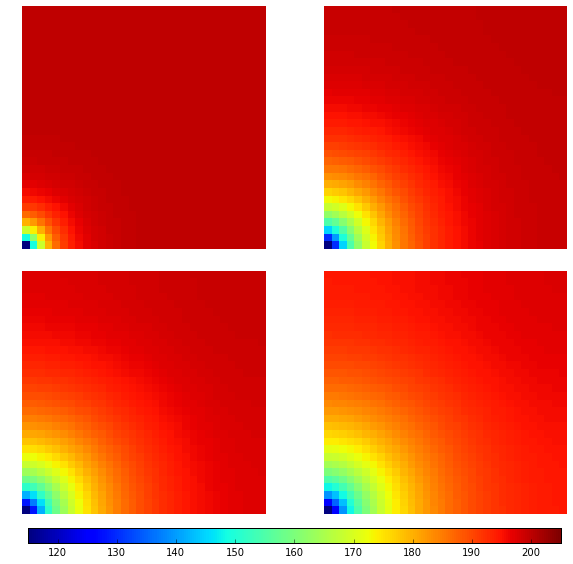

In [157]:
## Plot results
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,2)
for ax, currSol in zip(axes.flat, [sol[1], sol[8], sol[13], sol[20]]):
    im = ax.imshow(currSol["pressure"].reshape(n, n)/bar, interpolation="nearest")
    ax.invert_yaxis()
    ax.axis("off")
    plt.tight_layout()
    im.set_clim([115, 205])
plt.tight_layout()

plt.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([.13, .05, .74, .025])
fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
#plt.savefig("latex/fig/pressure-over-time-python.eps")

In [128]:
import os
print(os.getcwd())
plt.savefig("latex/fig/pressure-over-time-python.eps")
plt.show()

Z:\tma4500-project


In [131]:
for p in sol[20]["pressure"].A1:
    print("%.15f" % p)

10447823.635344982147217
12486252.445092201232910
13696659.783642042428255
14522375.775171738117933
15137582.032466188073158
15621999.478330394253135
16017109.684487178921700
16346800.519536046311259
16625936.155332168564200
16864323.906216379255056
17068728.300256498157978
17243974.685455374419689
17393592.623590961098671
17520210.264422181993723
17625805.988349027931690
17711874.079553157091141
17779536.276274673640728
17829617.794441837817430
17862699.012573584914207
17879149.659524347633123
12486252.445092201232910
13279859.578320402652025
14065051.096034744754434
14721399.823991585522890
15258444.670495396479964
15701910.456342376768589
16073275.869879035279155
16388085.348528863862157
16657328.492575045675039
16888840.148147936910391
17088301.335502978414297
17259904.133544094860554
17406788.914801079779863
17531334.808667108416557
17635355.778025366365910
17720235.079550851136446
17787018.568315014243126
17836479.734028249979019
17869164.661638554185629
17885422.133236516267061


In [149]:
get_color = plt.cm.get_cmap("jet")
get_color(np.arange(1, 10)/10)

array([[ 0.        ,  0.        ,  0.9456328 ,  1.        ],
       [ 0.        ,  0.3       ,  1.        ,  1.        ],
       [ 0.        ,  0.69215686,  1.        ,  1.        ],
       [ 0.16129032,  1.        ,  0.80645161,  1.        ],
       [ 0.49019608,  1.        ,  0.47754586,  1.        ],
       [ 0.80645161,  1.        ,  0.16129032,  1.        ],
       [ 1.        ,  0.77051561,  0.        ,  1.        ],
       [ 1.        ,  0.40740741,  0.        ,  1.        ],
       [ 0.9456328 ,  0.02977487,  0.        ,  1.        ]])